In [1]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import numpy as np
import pandas as pd
import os
import matplotlib2tikz
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=4, rc={"lines.markersize": 15})
plt.rc('hatch', color='white', linewidth=4)
plt.rcParams.update({
    "font.family": "serif",
     "font.serif": [] ,
      "font.sans-serif": []  })

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results'


SYSTEM_COLOR = sns.color_palette()[0]
BASELINE_COLOR = sns.color_palette()[1]

WRITE_DIRECTORY_ROOT = \
'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/papers/images/experiment-results'

output_directory = WRITE_DIRECTORY_ROOT + '/openml/model_materialization'
def create_folder(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

In [2]:
MODE = 'remote'
result_folder = ROOT_RESULT_FOLDER + '/' + MODE + '/model_materialization/openml'
result_file = result_folder + '/cloud-41/2019-10-14/13-41.csv'

In [3]:
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'pipeline', 'setup', 'type', 'mat_budget','score',
    'current_run_time', 'best_setup', 'best_pipeline', 'best_score',
    'best_run_time', 'total_run_time'
]

method_map = {'optimized': 'CO', 'baseline': 'OML'}
execution_times = pd.read_csv(result_file, header=None, names=HEADERS)

execution_times['cumulative_best_run_time'] = execution_times.groupby(['exp_id', 'type','mat_budget'])['best_run_time'].apply(lambda x: x.cumsum())
execution_times['cumulative_run_time'] = execution_times.groupby(['exp_id', 'type','mat_budget'])['total_run_time'].apply(lambda x: x.cumsum())
execution_times['mat_budget'] = execution_times['mat_budget'] / (1024. * 1024.)
execution_times['cumulative_current_run_time'] = execution_times.groupby(['exp_id', 'type','mat_budget'])['current_run_time'].apply(lambda x: x.cumsum())
execution_times['workload'] = execution_times.groupby(['exp_id', 'type','mat_budget']).cumcount() + 1
execution_times['type'] = execution_times['type'].replace(method_map)

In [4]:
def plot_executions_time(df, y='cumulative_run_time',loc=None):
    plt.figure(figsize=(7,4))
    plot = sns.lineplot(
        data=df,
        x='workload',
        y=y,
        hue='type',
        style='type',
        lw=3,
        hue_order=['OML', 'CO'],
        dashes={
            'CO': (1, 0),
            'OML': (1, 1)
        },
        palette={
            'CO': SYSTEM_COLOR,
            'OML': BASELINE_COLOR
        },
        legend='brief')

    legend = plt.legend(
            loc='upper left',
            handletextpad=0.1,
            labelspacing=0.0,
            bbox_to_anchor=(-.08, 1.3))
    legend.texts[0].set_text("")
    for line in legend.get_lines():
        line.set_linewidth(3.0)
    plot.set_xlabel('OpenML Workload', fontsize=30)
    plot.set_ylabel('Cumulative Run Time (s)', fontsize=30)
    plt.tick_params(labelsize=30)

    if loc is not None:
        plt.savefig(loc, bbox_inches ='tight')

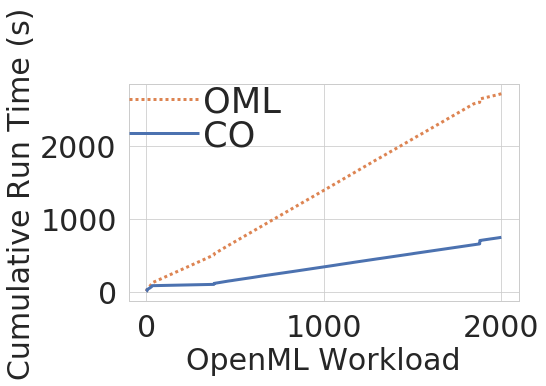

In [5]:
df = execution_times[(execution_times.mat_budget == 0.1) | (execution_times.type == 'OML')]
#plot_executions_time(df, y='cumulative_run_time')
plot_executions_time(df, y='cumulative_run_time',loc=output_directory+'/cumulative-runtime.pgf')


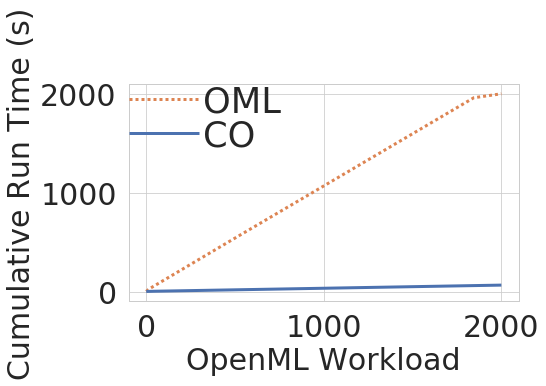

In [6]:
#plot_executions_time(df, y='cumulative_best_run_time')
plot_executions_time(df, y='cumulative_best_run_time',loc=output_directory+'/bestpipeline-overhead.pgf')

In [8]:
def best_current_runs(df, loc=None):
    plt.figure(figsize=(10,4))
    plot = sns.lineplot(
        data=df,
        x='workload',
        y='cumulative_current_run_time',
        hue='type',
        style='type',
        #markers=["^", "o"],
        lw=3,
        hue_order=['OML', 'CO'],
       # style_order = ['baseline', 'optimized'],
        dashes=[(2, 2), (1, 0)],
        palette={
            'CO': SYSTEM_COLOR,
            'OML': BASELINE_COLOR
        },
        legend='brief')

    legend = plot.legend()
    legend.texts[0].set_text("")
    for line in legend.get_lines():
        line.set_linewidth(3.0)
    #top = df['run_time'].max()
    #cat.set_axis_labels('Execution Number', 'Run Time (s)')
    plot.set_xlabel('Workload', fontsize=22)
    plot.set_ylabel('Cumulative Run Time (s)', fontsize=22)
    #plot.set_xlim((1,2))
    #plot.set_ylim((0,2200))
    #plot.set_xticks(range(1,9))
    #plot.set_xticklabels(range(1,9))
    if loc is not None:
        plt.savefig(loc, bbox_inches ='tight')

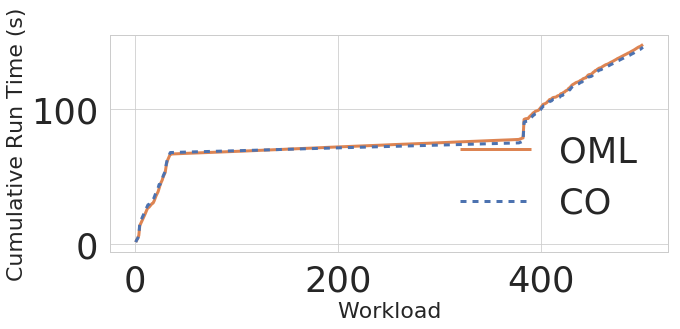

In [9]:
best_current_runs(execution_times)

In [69]:
test = df[df.type == 'CO']

In [70]:
test

,timestamp,exp_id,repo,pipeline,setup,type,mat_budget,score,current_run_time,best_setup,best_pipeline,best_score,best_run_time,total_run_time,cumulative_best_run_time,cumulative_run_time,cumulative_current_run_time,workload
6000,14:57:59,5E2BA620,openml,5804,36487,CO,0.1,0.80,1.573871,5804,36487,0.80,1.573871,1.573888,1.573871,1.573888,1.573871,1
6001,14:57:59,5E2BA620,openml,5909,36567,CO,0.1,0.80,1.736994,5804,36487,0.80,0.072983,1.809996,1.646854,3.383884,3.310865,2
6002,14:57:59,5E2BA620,openml,5910,36868,CO,0.1,0.79,0.818491,5804,36487,0.80,0.061125,0.879629,1.707979,4.263513,4.129356,3
6003,14:57:59,5E2BA620,openml,5913,43851,CO,0.1,0.71,1.692883,5804,36487,0.80,0.069049,1.761950,1.777028,6.025463,5.822239,4
6004,14:57:59,5E2BA620,openml,5914,44102,CO,0.1,0.70,19.550238,5804,36487,0.80,0.073539,19.623809,1.850567,25.649272,25.372477,5
6005,14:57:59,5E2BA620,openml,5909,47569,CO,0.1,0.80,1.561593,5804,36487,0.80,0.066991,1.628610,1.917558,27.277882,26.934070,6
6006,14:57:59,5E2BA620,openml,5909,47570,CO,0.1,0.80,1.573588,5804,36487,0.80,0.068362,1.641967,1.985920,28.919849,28.507658,7
6007,14:57:59,5E2BA620,openml,5909,47571,CO,0.1,0.80,1.667327,5804,36487,0.80,0.079465,1.746822,2.065385,30.666671,30.174985,8
6008,14:57:59,5E2BA620,openml,5909,47572,CO,0.1,0.80,1.701707,5804,36487,0.80,0.083108,1.784873,2.148493,32.451544,31.876692,9
6009,14:57:59,5E2BA620,openml,5909,47573,CO,0.1,0.80,1.814575,5804,36487,0.80,0.071359,1.885957,2.219852,34.337501,33.691267,10
